# Imports

In [1]:
import numpy as np
np.random.seed(10)

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Library Functions

In [2]:
def accuracy_score1(y_true, y_pred):
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Check if lengths match
    assert len(y_true) == len(y_pred), "True and predicted labels must have the same length."
    
    correct_predictions = np.sum(y_true == y_pred)
    
    accuracy = correct_predictions / len(y_true)
    
    return accuracy

def confusion_matrix1(y_true, y_pred):

    # Convert lists to arrays if they aren't already
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    cm = np.zeros((len(np.unique(y_true)), len(np.unique(y_pred))))
    
    # Fill confusion matrix
    for i, true_label in enumerate(np.unique(y_true)):
        for j, pred_label in enumerate(np.unique(y_pred)):
            cm[i, j] = np.sum((y_true == true_label) & (y_pred == pred_label))
    
    return cm
def train_test_split1(features, labels, test_size=0.2, shuffle=True):
    num_samples = features.shape[0]
    num_test_samples = int(num_samples * test_size)
    
    # Shuffle the data if requested
    if shuffle:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        features = features[indices]
        labels = labels[indices]
    
    # Split the data
    test_indices = np.arange(num_test_samples)
    train_indices = np.arange(num_samples)[num_test_samples:]
    
    # Extract the training and testing datasets
    X_train = features[train_indices]
    X_test = features[test_indices]
    Y_train = labels[train_indices]
    Y_test = labels[test_indices]
    
    return X_train, X_test, Y_train, Y_test

def calculate_metrics(y_true, y_pred):
    if isinstance(y_true, pd.Series):
        y_true = y_true.values
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.values
    
    # Confusion Matrix
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    # Accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    # Precision
    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)
    
    # Recall
    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)
    
    # F1 Score
    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score
    }


# The Data

Since this is somewhat of a tutorial, we will use a very basic Multi-Layer Perceptron to predict if a set of passengers survived; as a feature, we will only use the *Passenger Class* for sake of simplicity. We then split the set of features and labels into a training set and a test set.

In [3]:
data = pd.read_csv('../input/titanic/train.csv')
# We define a dictionary to transform the 0,1 values in the labels to a String that defines the fate of the passenger
dict_live = { 
    0 : 'Perished',
    1 : 'Survived'
}

# We define a dictionary to binarize the sex
dict_sex = {
    'male' : 0,
    'female' : 1
}

# We apply the dictionary using a lambda function and the pandas .apply() module
data['Bsex'] = data['Sex'].apply(lambda x : dict_sex[x])


# Now the features are a 2 column matrix whose entries are the Class (1,2,3) and the Sex (0,1) of the passengers
features = data[['Pclass', 'Bsex']].to_numpy()
labels = data['Survived'].to_numpy()

# split into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split1(features, labels, test_size=0.30)

print('Training records:',Y_train.size)
print('Test records:',Y_test.size)

Training records: 624
Test records: 267


In [4]:
features

array([[3, 0],
       [1, 1],
       [3, 1],
       ...,
       [3, 1],
       [1, 0],
       [3, 0]])


In the **Activation_function** class we have
* **ReLU_act, sigmoid_act**: these are the activation functions. They can be easily generalized (LeakyReLU, ParametricReLU, etc.)

In [5]:
def sigmoid_act(x, der=False):
    if (der==True) : #derivative of the sigmoid
        f = 1/(1+ np.exp(- x))*(1-1/(1+ np.exp(- x)))
    else : # sigmoid
        f = 1/(1+ np.exp(- x))
    return f

def ReLU_act(x, der=False):
    if (der == True): # the derivative of the ReLU is the Heaviside Theta
        f = np.heaviside(x, 1)
    else :
        f = np.maximum(x, 0)
    return f

In the **layers** class we have
* **layer**: it eats two imputs, the number of neurons and the activation function (as a string); it returns a tuple of the two. The idea is to leave room for a generalization of the *layers.layer* method later on by adding multiple layer type (i.e. Pooling or Convolutional layers for the CNN).

In [6]:
class layers :     
    def layer(p=4, activation = 'ReLU'):
        return (p, activation)

# The ANN as a Class

We want now to implement the code as Class for Python, so that we could easiliy generalize it; the goal is to have a class from which we can instantiate an object "Neural Network", and add to it as many hidden layers with as many neurons we want, with the desired activation functions and so on. To generalize further, we define also the *Activation_function* class and the *layers* class, so we may easily add more activation funtions or more different layers (such as Convolutional or Pooling layers for Convolutional Neural Networks).

Within the ANN class, we define the following methods:
* **add**: it eats a tuple ( int(number_of_neurons), string(activation_function) ), i.e. the output of the ANN.layer method. It is a void method. It updates the HiddenLayer string defined by the __init__ method. 
* **FeedForward**: it implements the Feed Forward layer by layer.
* **BackPropagation**: it implements the whole gradient descent mechanism; first, it computes the errors by implementing the backpropagation; then, it updates the ANN parameters by gradient descent. 
* **Fit**: this method eats the training features and labels and fits the ANN by calling iteratively *FeedForward* and *BackPropagation* methods. This allow us to easily modify (or generalize) either *FeedForward* or *BackPropagation* methods without altering the *Fit* method.
* **predict**: it eats the featurs and spits the label predictions. 
* **set_learning_rate**: by default the learning rate is initialized to be 1, but we can call this method to set it to a different value. 
* **get_accuracy, get_avg_accuracy**: these methods' aim is to return the cost function either at each step of the training process or averaging over 10 passengers, respectively.




In [7]:
class ANN:
    np.random.seed(10)
    
    '''
    HiddenLayer vector : will contain the Layers' info
    w, b, phi = (empty) arrays that will contain all the w, b and activation functions for all the Layers
    mu = cost function
    eta = a standard learning rate initialization. It can be modified by the 'set_learning_rate' method
    '''
    def __init__(self) :
        self.HiddenLayer = []
        self.w = []
        self.b = []
        self.phi = []
        self.mu = []
        self.el = []
        self.eta = 1 #set up the proper Learning Rate!!
        self.loss_name = 'mse'
    
    '''
    add method: to add layers to the network
    '''
    def add(self, lay = (4, 'ReLU') ):
        self.HiddenLayer.append(lay)
    
    '''
    FeedForward method: as explained before. 
    '''
    @staticmethod
    def FeedForward(w, b, phi, x):
        return phi(np.dot(w, x) + b)
        
    '''
    BackPropagation algorithm implementing the Gradient Descent 
    '''
    def BackPropagation(self, x, z, Y, w, b, phi):
        self.delta = []
        
        # We initialize ausiliar w and b that are used only inside the backpropagation algorithm once called        
        self.W = []
        self.B = []
        
        # We start computing the LAST error, the one for the OutPut Layer 
        self.delta.append(  (z[len(z)-1] - Y) * phi[len(z)-1](z[len(z)-1], der=True) )
        
        '''Now we BACKpropagate'''
        # We thus compute from next-to-last to first
        for i in range(0, len(z)-1):
            self.delta.append( np.dot( self.delta[i], w[len(z)- 1 - i] ) * phi[len(z)- 2 - i](z[len(z)- 2 - i], der=True) )
        
        # We have the error array ordered from last to first; we flip it to order it from first to last
        self.delta = np.flip(self.delta, 0)  
        
        # Now we define the delta as the error divided by the number of training samples
        self.delta = self.delta/self.X.shape[0] 
        
        '''GRADIENT DESCENT'''
        # We start from the first layer that is special, since it is connected to the Input Layer
        self.W.append( w[0] - self.eta * np.kron(self.delta[0], x).reshape( len(z[0]), x.shape[0] ) )
        self.B.append( b[0] - self.eta * self.delta[0] )
        
        # We now descend for all the other Hidden Layers + OutPut Layer
        for i in range(1, len(z)):
            self.W.append( w[i] - self.eta * np.kron(self.delta[i], z[i-1]).reshape(len(z[i]), len(z[i-1])) )
            self.B.append( b[i] - self.eta * self.delta[i] )
        
        # We return the descended parameters w, b
        return np.array(self.W), np.array(self.B)
    
    
    '''
    Fit method: it calls FeedForward and Backpropagation methods
    '''
    def Fit(self, X_train, Y_train, num_epochs = 1):            
        print('Start fitting...')
        '''
        Input layer
        '''
        self.X = X_train
        self.Y = Y_train
        
        '''
        We now initialize the Network by retrieving the Hidden Layers and concatenating them 
        '''
        print('Model recap: \n')
        print('You are fitting an ANN with the following amount of layers: ', len(self.HiddenLayer))
        
        for i in range(0, len(self.HiddenLayer)) :
            print('Layer ', i+1)
            print('Number of neurons: ', self.HiddenLayer[i][0])
            if i==0:
                self.w.append( np.random.randn(self.HiddenLayer[i][0] , self.X.shape[1])/np.sqrt(2/self.X.shape[1]) )
                self.b.append( np.random.randn(self.HiddenLayer[i][0])/np.sqrt(2/self.X.shape[1]))
                
                # Initialize the Activation function
                for act in Activation_function.list_act():
                    if self.HiddenLayer[i][1] == act :
                        self.phi.append(Activation_function.get_act(act))
                        print('\tActivation: ', act)

            else :
                self.w.append( np.random.randn(self.HiddenLayer[i][0] , self.HiddenLayer[i-1][0] )/np.sqrt(2/self.HiddenLayer[i-1][0]))
                self.b.append( np.random.randn(self.HiddenLayer[i][0])/np.sqrt(2/self.HiddenLayer[i-1][0]))

                # Initialize the Activation function
                for act in Activation_function.list_act():
                    if self.HiddenLayer[i][1] == act :
                        self.phi.append(Activation_function.get_act(act))
                        print('\tActivation: ', act)
            
        '''
        Now we start the Loop over the training dataset
        '''
        epoch_count = 0 
        for epoch in range(num_epochs):
            total_loss = 0
            for I in range(0, self.X.shape[0]): # loop over the training set
                '''
                Now we start the feed forward
                '''  
                self.z = []
            
                self.z.append( self.FeedForward(self.w[0], self.b[0], self.phi[0], self.X[I]) ) # First layers
            
                for i in range(1, len(self.HiddenLayer)): #Looping over layers
                    self.z.append( self.FeedForward(self.w[i] , self.b[i], self.phi[i], self.z[i-1] ) )
        
            
                '''
                Here we backpropagate
                '''      
                self.w, self.b  = self.BackPropagation(self.X[I], self.z, self.Y[I], self.w, self.b, self.phi)
            
                '''
                Compute cost function
                ''' 
                
                loss = self.compute_cost(I)
                self.mu.append(loss)
                total_loss += loss
            epoch_count += 1
            print(f"Epoch {epoch_count} completed. Loss: {total_loss / self.X.shape[0]}")
            self.el.append(total_loss/ self.X.shape[0])
        print('Fit done. \n')
        

    
    '''
    predict method
    '''
    def compute_cost(self, I):
        if self.loss_name == 'mse':
            cost = np.mean((self.z[-1] - self.Y[I])**2)
        elif self.loss_name == 'mae':
            cost = np.mean(np.abs(self.z[-1] - self.Y[I]))
        else:
            raise ValueError("Invalid loss name")
        return cost
    
    def predict(self, X_test):
        
        print('Starting predictions...')
        
        self.pred = []
        self.XX = X_test
        
        for I in range(0, self.XX.shape[0]): # loop over the training set
            
            '''
            Now we start the feed forward
            '''  
            self.z = []
            
            self.z.append(self.FeedForward(self.w[0] , self.b[0], self.phi[0], self.XX[I])) #First layer
    
            for i in range(1, len(self.HiddenLayer)) : # loop over the layers
                self.z.append( self.FeedForward(self.w[i] , self.b[i], self.phi[i], self.z[i-1]))
       
            # Append the prediction;
            # We now need a binary classifier; we this apply an Heaviside Theta and we set to 0.5 the threshold
            # if y < 0.5 the output is zero, otherwise is zero
            self.pred.append( np.heaviside(  self.z[-1] - 0.5, 1)[0] ) # NB: self.z[-1]  is the last element of the self.z list
        
        print('Predictions done. \n')

        return np.array(self.pred)
    def get_losses(self):
        return np.array(self.el)
    def set_loss_function(self, loss_name):
        if loss_name.lower() not in ['mse', 'mae']:
            raise ValueError("Invalid loss function. Please choose 'mse' or 'mae'.")
        self.loss_name = loss_name.lower()
        print('Loss Function is: ',self.loss_name)
    def set_learning_rate(self, et=1):
        self.eta = et
        
class Activation_function(ANN):
    import numpy as np
    
    def __init__(self) :
        super().__init__()
        
    def list_act():
        return ['sigmoid', 'ReLU']
    
    def get_act(string = 'ReLU'):
        if string == 'ReLU':
            return ReLU_act
        elif string == 'sigmoid':
            return sigmoid_act
        else :
            return sigmoid_act

# ANN Training & Comparison

Loss Function is:  mse
Start fitting...
Model recap: 

You are fitting an ANN with the following amount of layers:  4
Layer  1
Number of neurons:  24
	Activation:  ReLU
Layer  2
Number of neurons:  24
	Activation:  sigmoid
Layer  3
Number of neurons:  6
	Activation:  ReLU
Layer  4
Number of neurons:  1
	Activation:  sigmoid
Epoch 1 completed. Loss: 0.20595596663835622
Epoch 2 completed. Loss: 0.18533202306476085
Epoch 3 completed. Loss: 0.17852759524252404
Epoch 4 completed. Loss: 0.17486622725958448
Epoch 5 completed. Loss: 0.1742146954143242
Epoch 6 completed. Loss: 0.1743630703770811
Epoch 7 completed. Loss: 0.17478753140672287
Epoch 8 completed. Loss: 0.17531989470609544
Epoch 9 completed. Loss: 0.17584479106977985
Epoch 10 completed. Loss: 0.1763527750207287
Epoch 11 completed. Loss: 0.1768121456799445
Epoch 12 completed. Loss: 0.1772073131742255
Epoch 13 completed. Loss: 0.17751764952211305
Epoch 14 completed. Loss: 0.17775324849269963
Epoch 15 completed. Loss: 0.1779204921070460

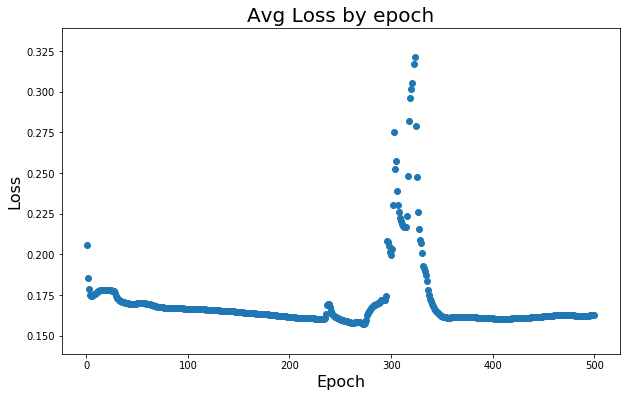

Starting predictions...
Predictions done. 

{'Accuracy': 0.8052434456928839, 'Precision': 0.735632183908046, 'Recall': 0.6881720430107527, 'F1 Score': 0.7111111111111111}


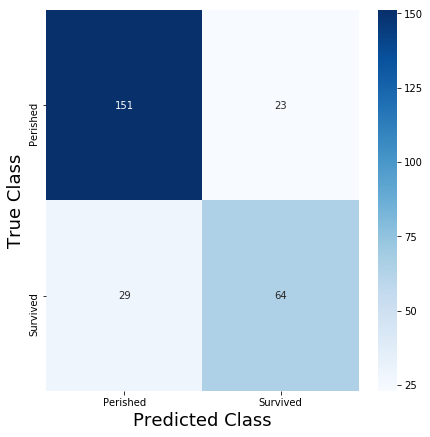

In [8]:
model = ANN()

model.add(layers.layer(24, 'ReLU'))
model.add(layers.layer(24, 'sigmoid'))
model.add(layers.layer(6, 'ReLU'))
# model.add(layers.layer(4, 'ReLU'))
model.add(layers.layer(1, 'sigmoid'))
model.set_loss_function('mse')
model.set_learning_rate(0.1)

num_epochs = 500
model.Fit(X_train, Y_train, num_epochs)
el = model.get_losses()
# acc_avg_val = model.get_avg_accuracy()
# print()
plt.figure(figsize=(10,6))
plt.scatter(np.arange(1, num_epochs+1), el, label='mu')
plt.title('Avg Loss by epoch', fontsize=20)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

predictions = model.predict(X_test)

# Plot the confusion matrix
cm = confusion_matrix1(Y_test, predictions)
print(calculate_metrics(Y_test, predictions))

df_cm = pd.DataFrame(cm, index = [dict_live[i] for i in range(0,2)], columns = [dict_live[i] for i in range(0,2)])
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Class", fontsize=18)
plt.ylabel("True Class", fontsize=18)
plt.show()

# Submission to test model!

In [9]:
test_data = pd.read_csv('../input/titanic/test.csv')

test_data.head(4)

# We apply the dictionary using a lambda function and the pandas .apply() module
test_data['Bsex'] = test_data['Sex'].apply(lambda x : dict_sex[x])


X_t = test_data[['Pclass', 'Bsex']].to_numpy()

test_predictions = model.predict(X_t)
submission = pd.DataFrame({
        "PassengerId": test_data["PassengerId"],
        "Survived": test_predictions
    })


submission['Survived'] = submission['Survived'].astype(int)
# Export it in a 'Comma Separated Values' (CSV) file
import os
os.chdir(r'../working')
submission.to_csv(r'submission.csv', index=False)
# Creating a link to download the .csv file we created
from IPython.display import FileLink
FileLink(r'submission.csv')
# submission.head(5)

Starting predictions...
Predictions done. 



/kaggle/working/submission.csv